In [1]:
%matplotlib inline

import datetime as dt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from tqdm.notebook import tqdm

from datetime import datetime

#from scipy.stats.stats import mode, pearsonr

In [2]:
# Loading dataset.

custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%y %H:%M")

df = pd.read_csv('customer_supermarket.csv', sep='\t', decimal=',',
                 parse_dates=['BasketDate'], date_parser=custom_date_parser, index_col=0)

df['CustomerID'] = df['CustomerID'].astype(float)

# Data Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  float64       
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.4+ MB


In [4]:
df.isnull().sum()

BasketID               0
BasketDate             0
Sale                   0
CustomerID         65080
CustomerCountry        0
ProdID                 0
ProdDescr            753
Qta                    0
dtype: int64

13% of CustomerID are null, 0.15% of ProdDescr are null.

In [5]:
df.describe()

,Sale,CustomerID,Qta
count,471910.000000,406830.000000,471910.000000
mean,4.030945,15287.684160,10.716533
std,83.769380,1713.603074,231.355136
min,-11062.060000,12346.000000,-80995.000000
25%,1.250000,13953.000000,1.000000
50%,2.080000,15152.000000,4.000000
75%,3.750000,16791.000000,12.000000
max,38970.000000,18287.000000,80995.000000


Detected anomalies:
- float customer ids
- negative sales;
- negative quantities;
- huge maximum sale;
- huge maximum quantity.

In [6]:
df[df['Sale'] < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1


The records with negative sale have a leading 'A', that we suppose means "aborted transaction".

In [7]:
df[df['Qta'] < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,D,Discount,-1
154,C536383,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


All the records with negative quantities have BaskedIDs with a leading 'C', that we assume means "canceled order".
The order's entries have been modified in-place, so...

In [8]:
# check that there are no useful basketid for recovering the customerid (too slow)

recover_basket = []

last_basket = None
with tqdm(total=len(df)) as pbar:  
    for index, row in df.iterrows():
        pbar.update(1)
        if last_basket != row['BasketID']:
            last_basket = row['BasketID']
            data = df[df['BasketID'] == row['BasketID']]
            all_nan = data['CustomerID'].isnull().values.all()
            any_nan = data['CustomerID'].isnull().values.any()
            if (all_nan == False and any_nan == True): 
                recover_basket.append(row['BasketID'])

recover_basket

[]

In [9]:
df.dropna(subset=['CustomerID'], inplace=True)

In [10]:
np.any(np.where(df['CustomerID'].apply(lambda x: x.is_integer()), 0, 1))

False

In [11]:
df['CustomerID'] = df['CustomerID'].astype(int)

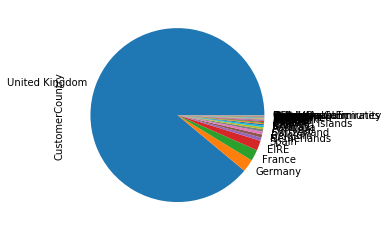

In [12]:
# Customers' nationalities.

countries = df['CustomerCountry'].value_counts()
ax = countries.plot.pie()

All the countries are real, but there are 340 unspecified records' countries.

## Data distribution and quality

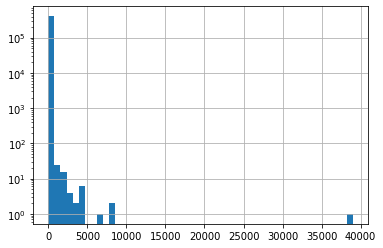

In [13]:
# Sales distribution.

ax = df.Sale.hist(log=True, bins=50)

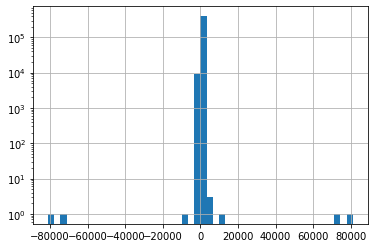

In [14]:
# Qta distribution.

ax = df.Qta.hist(log=True, bins=50)

The majority of purchases have low price.

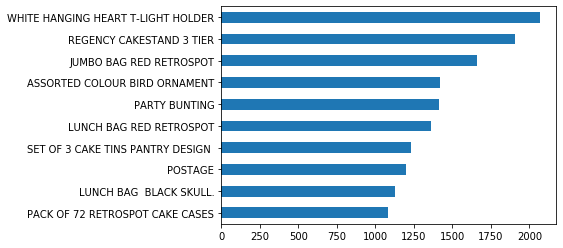

In [15]:
# Top-10 frequent products.

ax = df['ProdDescr'].value_counts().head(10).plot(kind='barh')
ax.invert_yaxis()

The first 7 most sold products are legit ones, but the 8th is "postage", that we assume is related to the shipping, and we're not considering it as a valid product.

After a deeper analysis we've detected some unusual and erroneous ProdID and ProdDescr, and we've put them in two files: blacklist_prod_descr.csv and blacklist_prod_id.csv. An example is a descrition that mocks a colleague, also with typos: "alan hodge cant mamage this section".

Analyzing the data, we also found this relation: (ProdDescr = null) $\Rightarrow$ (CustomerID = null $\land$ Sale = 0).

### CustomerID analysis

Given the high number of null CustomerIDs, we decided to consider them valid, under certain conditions (see next).

# Data preparation

## New features

We want to analyze the customers' behavior on the day of the week.

In [16]:
df['BasketDay'] = df['BasketDate'].dt.day_name()

As said before, the BasketID starting with a 'C' have been considered canceled. We added a new booleand field "Canceled" to keep track of them, then we removed the 'C' from the BasketID, and we reversed the quantity for further simplicity.

In [17]:
canceled = "C"
df['Canceled'] = df['BasketID'].apply(lambda x : x.startswith(canceled))
df['BasketID'] = df['BasketID'].apply(lambda x : x[1:] if x.startswith(canceled) else x)
df['Qta'] = np.where(df['Canceled'], abs(df['Qta']), df['Qta'])

## Data cleaning

The aborted transactions are already dropped because of the null CustomerID.

In [18]:
df[df['Sale'] < 0]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,BasketDay,Canceled


In [19]:
df['BasketID'] = df['BasketID'].astype(int)

We compute the total price of every row.

In [20]:
df['Total'] = df['Sale'] * df['Qta']

Then we remove the rows with bad ProdDescr and ProdID.

In [21]:
# To find bad descriptions.
#df['ProdDescr'].value_counts().to_csv('prodlist.csv')

In [22]:
with open('blacklist_prod_descr.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdDescr'].isin(blacklist)]

In [23]:
# If len < 5 or > 6, probably not a valid product. We made another blacklist.

with open('blacklist_prod_id.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdID'].isin(blacklist)]

We found few zero prices, and in most of the cases, also null ProdDescr. We decided to get rid of them.

In [24]:
df = df[~(df['Sale'] == 0)]

There are still too small values of Sale (less than 1 penny). We remove them.

In [25]:
df = df[~(df['Sale'] < 0.01)]

5.27% of BasketIDs removed.

In [26]:
# Percentage for each country dropped.

countries_after = df['CustomerCountry'].value_counts()
dropped = (1 - countries_after.divide(countries)) * 100
dropped

United Kingdom          0.177684
Germany                 4.212744
France                  3.815356
EIRE                    1.429526
Spain                   2.605606
Netherlands             1.897933
Belgium                 4.736588
Switzerland             1.811401
Portugal                2.972973
Australia               0.397141
Norway                  2.486188
Italy                   2.490660
Channel Islands         0.659631
Finland                 6.043165
Cyprus                  0.482315
Sweden                  5.411255
Austria                 3.491272
Denmark                 3.598972
Japan                   0.837989
Poland                  1.466276
USA                     0.000000
Israel                  0.000000
Unspecified             0.000000
Singapore               6.113537
Iceland                 0.000000
Canada                  0.662252
Greece                  2.739726
Malta                   3.149606
United Arab Emirates    1.470588
European Community      4.918033
RSA       

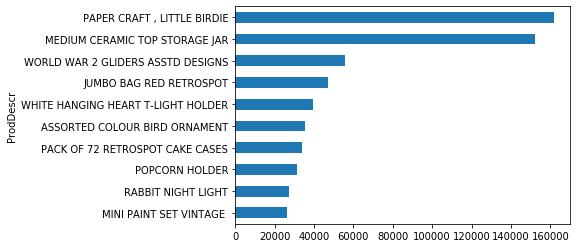

In [27]:
# New top-10 products.

grouped_data = df.groupby(['ProdDescr']).agg({'Qta': 'sum'})

ax = grouped_data['Qta'].nlargest(10).plot(kind='barh')
ax.invert_yaxis()

In [28]:
df.describe()

,BasketID,Sale,CustomerID,Qta,Total
count,404876.000000,404876.000000,404876.000000,404876.000000,404876.000000
mean,560584.082717,2.901366,15295.253282,13.403704,22.810614
std,13106.540726,4.430949,1710.404209,248.399725,422.673214
min,536365.000000,0.030000,12346.000000,1.000000,0.060000
25%,549130.000000,1.250000,13969.000000,2.000000,4.680000
50%,561873.500000,1.950000,15159.000000,5.000000,11.700000
75%,572066.000000,3.750000,16794.000000,12.000000,19.800000
max,581587.000000,649.500000,18287.000000,80995.000000,168469.600000


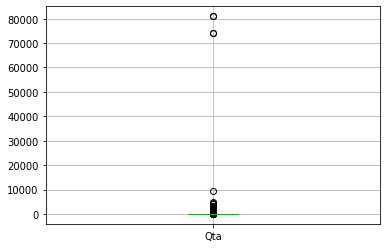

In [29]:
df.boxplot(column='Qta')

Deleting outliers

In [30]:
len(df[df['Qta'] > 60000])

4

In [31]:
df.drop(df[df.Qta > 60000].index, inplace=True)

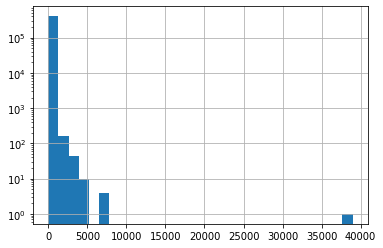

In [32]:
ax = df.Total.hist(log=True, bins=30)
#ax.set_xlim((0, 82000))

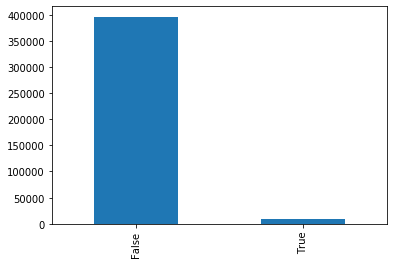

In [33]:
ax = df['Canceled'].value_counts().plot(kind='bar')

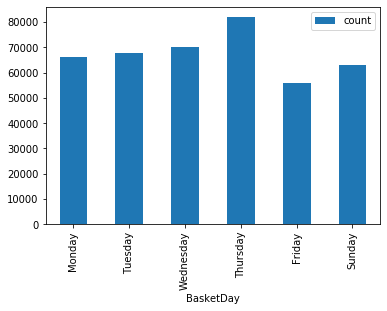

In [34]:
df['weekday_num'] = df['BasketDate'].dt.dayofweek
df_grouped = (df.groupby(['weekday_num', 'BasketDay']).size().reset_index(name="count"))
df_grouped.plot.bar(x="BasketDay", y="count");

There are no sales on saturday.

In [35]:
# filtered data: canceled and not_canceled orders

del df['weekday_num']
#del df['BasketDay']

canceled = df[df['Canceled']]


main_data = df[~(df['Canceled'])]

del main_data['Canceled']
del canceled['Canceled']

## Creating Indicators

In [36]:
customer_indicators = main_data.groupby(by='CustomerID', as_index=False).BasketDate.agg(['min', 'max'])
customer_indicators['Delta'] = (customer_indicators['max'] - customer_indicators['min']).dt.days + 1
del customer_indicators['min']
del customer_indicators['max']

In [37]:
# Shopping sessions.
#ss_total = not_canceled.groupby(['BasketID']).agg({'Qta': 'mean'})

#ax = ss_total.Qta.hist(bins=100000)
#ax.set_xlim((0, 100))

In [38]:
#ax = ss_total.plot.scatter(x='Qta', y='Total')

In [39]:
# total number of items purchased by a customer during its period of observation.

total_items = main_data.groupby('CustomerID').agg({'Qta': 'sum'})
total_items.columns = ['Total_items']

In [40]:
# total number of distinct items purchased by a customer during a period.

total_distinct_items = main_data.groupby('CustomerID')['ProdID'].nunique()
total_distinct_items = total_distinct_items.rename('Total_distinct_items')

In [41]:
# max number of items purchased by a customer during a shopping session.

temp = main_data.groupby(['BasketID','CustomerID']).agg({'Qta': 'sum'})
max_items = temp.groupby(['CustomerID']).agg({'Qta': 'max'})
max_items.columns = ['Max_items']
max_items

,Max_items
CustomerID,
12347,676
12348,1248
12349,630
12350,196
12352,125
...,...
18280,45
18281,54
18282,75


In [42]:
# entropy on shopping date for customer predictability.


entropies = []

customer_list = main_data.groupby(['CustomerID', 'BasketDay'], as_index=False).agg({'BasketDay': 'count'})

last_customer = None
for index, row in customer_list.iterrows():
    if last_customer != row['CustomerID']:
        last_customer = row['CustomerID']
        data = customer_list[customer_list['CustomerID'] == row['CustomerID']]
        prob = data['BasketDay']
        entropy = stats.entropy(prob)
        entropies.append(entropy)

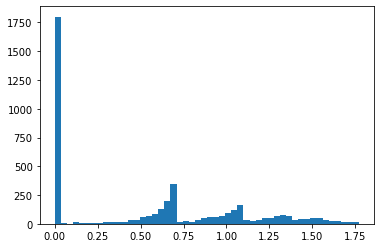

In [43]:
plt.hist(entropies, bins=50)
plt.show()

## Computing RFM indicators

In [44]:
# How many days since the last purchase?
recency = main_data.groupby(by='CustomerID', as_index=False)['BasketDate'].max()

last = main_data['BasketDate'].max() + dt.timedelta(days=1)

recency['Recency'] = recency['BasketDate'].apply(lambda x: (last - x).days)
del recency['BasketDate']
recency.head()

,CustomerID,Recency
0,12347,2
1,12348,75
2,12349,19
3,12350,310
4,12352,36


In [45]:
# How many times a customer has bought in this market?

frequency = main_data.groupby(by=['CustomerID'], as_index=False)['BasketID'].nunique()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12347,7
1,12348,4
2,12349,1
3,12350,1
4,12352,7


In [46]:
# How much has a customer spent?

monetary = main_data.groupby(by=['CustomerID'], as_index=False)['Total'].sum()
monetary.columns = ['CustomerID', 'Monetary']
monetary.head()

,CustomerID,Monetary
0,12347,4310.00
1,12348,1437.24
2,12349,1457.55
3,12350,294.40
4,12352,1385.74


In [47]:
median = main_data.groupby(by=['CustomerID', 'BasketID'], as_index=False)['Total'].sum()
median = median.groupby(by=['CustomerID'], as_index=False)['Total'].median()
median.columns = ['CustomerID', 'Median']
median.head()

,CustomerID,Median
0,12347,584.91
1,12348,298.50
2,12349,1457.55
3,12350,294.40
4,12352,226.25


In [48]:
# RFM table.

rfm = recency.merge(frequency.merge(monetary, on='CustomerID'), on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12347,2,7,4310.00
1,12348,75,4,1437.24
2,12349,19,1,1457.55
3,12350,310,1,294.40
4,12352,36,7,1385.74


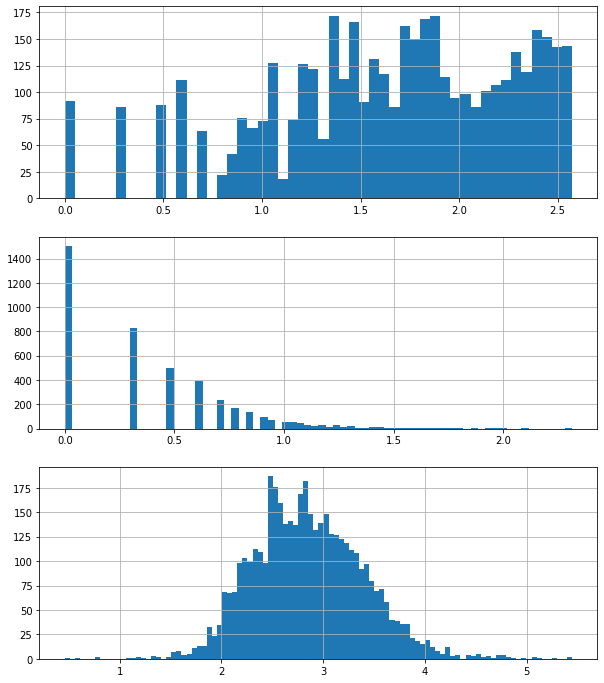

In [49]:
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log10, axis=1).round(3)

# plot the distribution of RFM values
f, ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); rfm_log.Recency.hist(bins=50, label='Recency')
plt.subplot(3, 1, 2); rfm_log.Frequency.hist(bins=70, label='Frequency')
plt.subplot(3, 1, 3); rfm_log.Monetary.hist(bins=100, label='Monetary')
plt.show()

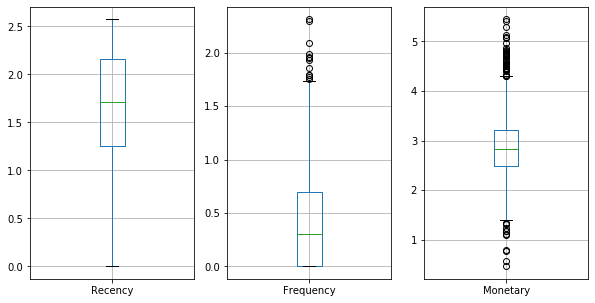

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
rfm_log.boxplot('Recency', ax=ax[0])
rfm_log.boxplot('Frequency', ax=ax[1])
rfm_log.boxplot('Monetary', ax=ax[2])

In [51]:
customer_indicators = customer_indicators.merge(rfm, on='CustomerID')
customer_indicators = customer_indicators.merge(total_items, on='CustomerID')
customer_indicators = customer_indicators.merge(total_distinct_items, on='CustomerID')
customer_indicators = customer_indicators.merge(max_items, on='CustomerID')
customer_indicators = customer_indicators.merge(median, on='CustomerID')
customer_indicators['Entropy'] = entropies

Text(0.5, 1, 'Correlation matrix')

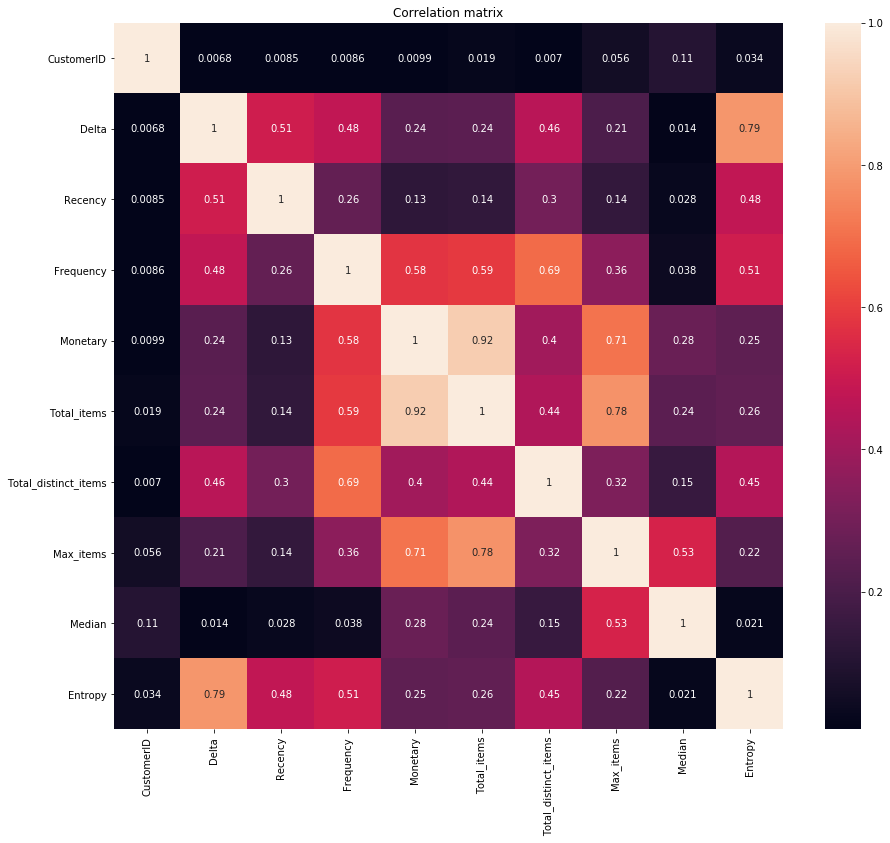

In [52]:
f, ax = plt.subplots(figsize=(15, 13))
correlation = customer_indicators.corr().abs()
ax = sns.heatmap(correlation, annot=True)
plt.title("Correlation matrix")

Text(0.5, 1, 'Correlation matrix')

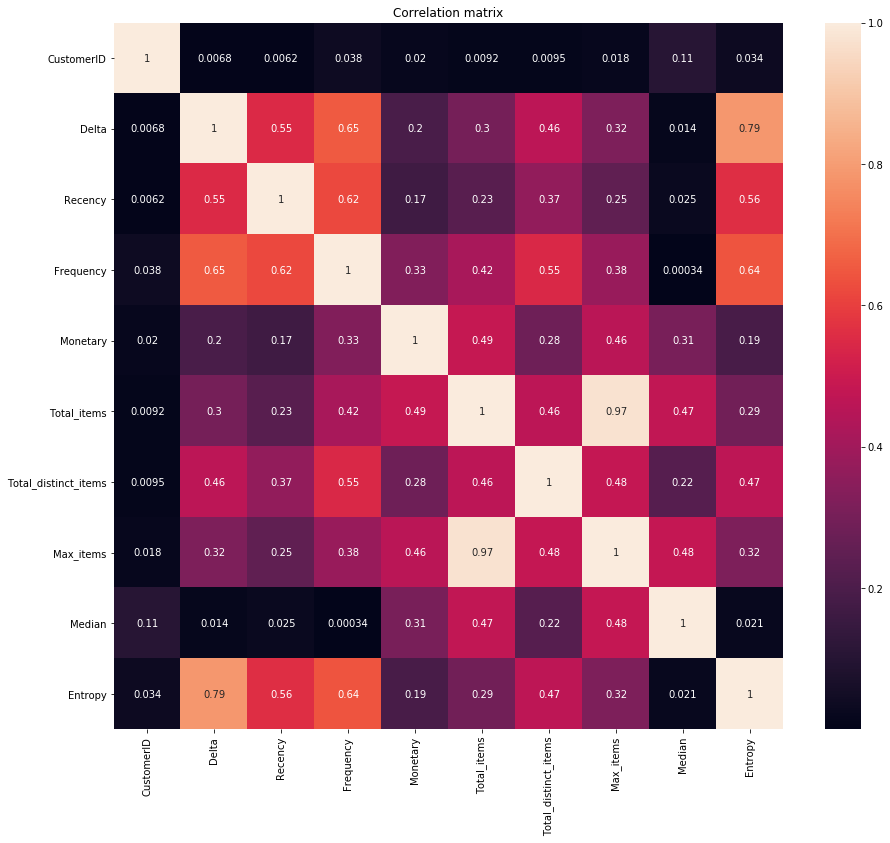

In [55]:
relative = customer_indicators.copy()

relative['Frequency'] = relative['Frequency'] / relative['Delta']
relative['Monetary'] = relative['Monetary'] / relative['Delta']
relative['Recency'] = relative['Recency'] / relative['Delta']
relative['Total_items'] = relative['Total_items'] / relative['Delta']
relative['Total_distinct_items'] = relative['Total_distinct_items'] / relative['Delta']
relative['Max_items'] = relative['Max_items'] / relative['Delta']


f, ax = plt.subplots(figsize=(15, 13))
correlation = relative.corr().abs()
ax = sns.heatmap(correlation, annot=True)
plt.title("Correlation matrix")

In [56]:
%store recency
%store frequency
%store monetary
%store rfm_log
%store customer_indicators

Stored 'recency' (DataFrame)
Stored 'frequency' (DataFrame)
Stored 'monetary' (DataFrame)
Stored 'rfm_log' (DataFrame)
Stored 'customer_indicators' (DataFrame)
